In [69]:
from sklearn.model_selection import train_test_split
import numpy as np             
import math
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.linalg as la

In [70]:
def func(X):
    return -np.sin(6*np.pi*X)**2+6*X**2-5*X**4+3/2

# Data
X = np.linspace(0, 1, 30)
y = func(X)
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# Use clone for splitting data and ensure requires_grad is set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)
y_mean = np.mean(y)
y_std = np.sqrt(np.var(y))

In [71]:
def negLogLikelihood(params, kernel):
    noise_y = params[0]
    theta = params[1:]
    temp = np.linalg.slogdet(noise_y*np.eye(X_train.shape[0])+kernel(X_train, X_train, theta))
    ll = -0.5*y_train.T@la.inv(noise_y*np.eye(X_train.shape[0])+kernel(X_train, X_train, theta))@y_train \
    - 0.5*temp.sign*temp.logabsdet \
    - 0.5*len(X)*np.log(np.sqrt((2*np.pi)))

    return -ll


def optimize_params(ranges, kernel, Ngrid):
    opt_params = opt.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    theta = opt_params[1:]
    return noise_var, theta


def conditional(X_train, y_train, X_test, noise_var, theta, kernel):
    mustar = kernel(X_test, X_train, theta)@la.inv(noise_var*np.eye(X_train.shape[0])+kernel(X_train, X_train, theta))@y_train
    Sigmastar = kernel(X_test, X_test, theta) \
        - kernel(X_test, X_train, theta)@la.inv(noise_var*np.eye(X_train.shape[0])+kernel(X_train, X_train, theta))@kernel(X_train, X_test, theta)

    return mustar, Sigmastar 


In [72]:
def periodic_kernel(X, X_prime, theta):
    var = theta[0]
    p = theta[1]
    ell = theta[2]
    return np.exp(-2*np.power(np.sin(np.pi*(X-X_prime)/p), 2)/np.power(ell, 2)*var)

def special_kernel(X, Xprime, eta):
    a = eta[0]
    b = eta[1]
    K = (1+X@Xprime.T)**2 + a * np.multiply.outer(np.sin(2*np.pi * X.reshape(-1)+b), np.sin(2*np.pi*Xprime.reshape(-1)+b))
    return K

kernel = special_kernel

Ngrid = 10
ranges = ((1.e-4, 5), (1.e-4, 5), (1.e-4, 5))
noise_var, theta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, theta)



optimal params: 0.5556444444444445 [1.00000000e-04 1.11118889e+00]


In [73]:
X_test = np.concatenate((X_test, np.zeros(10).reshape(-1, 1)))
prediction_mean_gp, Sigma_gp = conditional(X_train, y_train, X_test, noise_var, theta, kernel)
prediction_mean_gp = prediction_mean_gp[:10]
Sigma_gp = Sigma_gp[:10]
var_gp = np.diag(Sigma_gp)  
var_gp = var_gp.reshape(-1, 1)
X_test = X_test[:10]


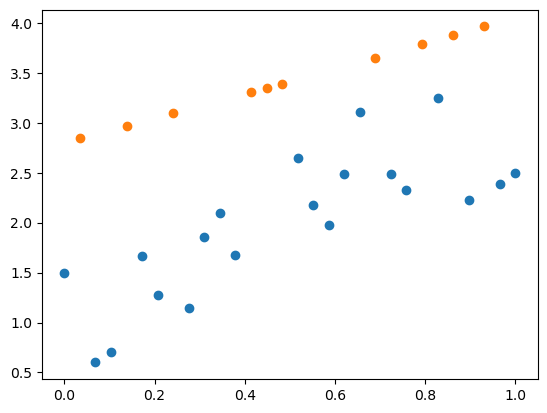

In [74]:
plt.scatter(X_train, y_train)
yout_m = prediction_mean_gp*y_std + y_mean
yout_v = var_gp*y_std**2
plt.scatter(X_test, yout_m)